# Rossman Store Sales Analysis
This analysis is based on the Kaggle data challenge to forecast Rossman Store's sales using store, promotion, and competitor data. This projects consists of three parts:

#### Part A - Exploratory Data Analysis  
#### Part B - Time Series Analysis & Predictive Modelling 
#### Part C - Results & Conclusions


In [1]:
# Import required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os

# statistics
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing store data
store = pd.read_csv('rossmann_store.csv')
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [3]:
# Importing train data
train = pd.read_csv('rossmann_train.csv', index_col='Date', parse_dates = True)
train

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1


In [4]:
# Importing test data
test = pd.read_csv('rossmann_test.csv')
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


## Part A - Exploratory Data Analysis (EDA)

- 1017209 observations of sales data
- from 2013-01-01 to 2015-09-17
- ordered sequence of values of a variable (here Sales) at equally spaced time intervals (daily, weekly, monthly, yearly)

#### EDA_ train data

In [5]:
# Extracting year, month, day and week, and making new column
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.isocalendar().week

train['SalePerCustomer'] = train['Sales']/train['Customers']

In [6]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [7]:
# Checking data when the stores were closed
train_store_closed = train[(train.Open == 0)]
train_store_closed.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


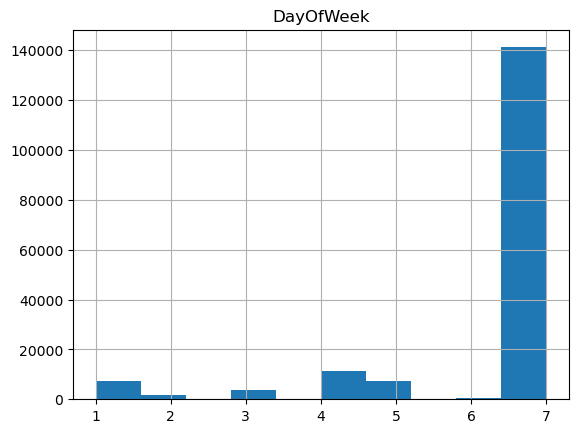

In [8]:
# Checking days when the stores were closed
train_store_closed.hist('DayOfWeek');

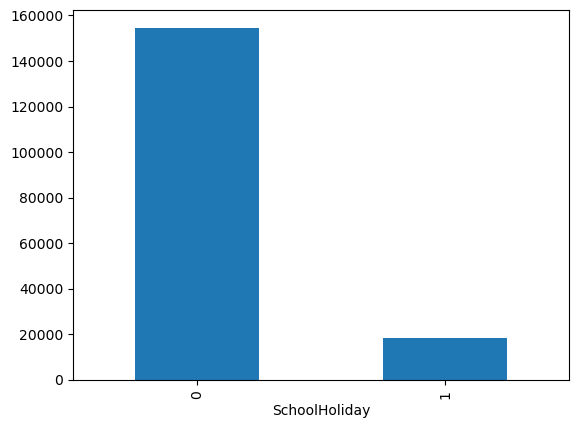

In [9]:
# Checking whether there was a school holiday when the store was closed
train_store_closed['SchoolHoliday'].value_counts().plot(kind='bar');

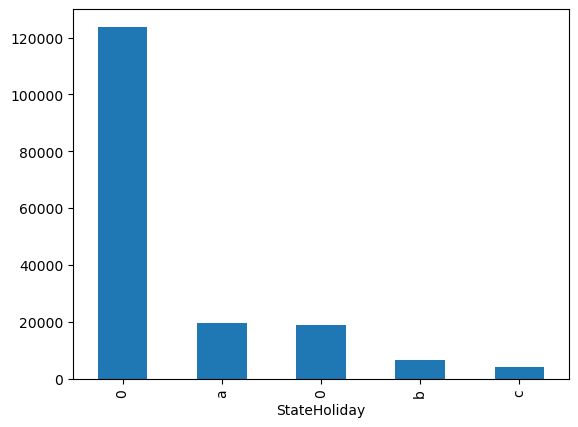

In [10]:
# Checking whether there was a state holiday when the store was closed
train_store_closed['StateHoliday'].value_counts().plot(kind='bar');

- stores were mostly closed on 7th day (Sunday)
- On other days: closed because of a school holiday or/and a state holiday:
    - a = public holiday
    - b = Easter holiday
    - c = Christmas
    - 0 = None


#### EDA: store data

In [11]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
# Checking missing values in store data 
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

- Only 3 observations have 'Competition Distance' missing.
- It's safe to replace these missing values with the median.

- Can't use the same approach with competition's existence (month and year)
- It is better to replace it with 0 (i.e launched recently)
- We'll also imput the missing values in promo with 0 as no information about promo is avaialable.

In [13]:
# Replacing missing values for Competiton distance with median
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace=True)

In [14]:
# No info about other columns - so replcae by 0
store.fillna(0, inplace=True)

In [15]:
# Checking test data
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [16]:
# Checking missing values
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [17]:
# Assuming stores open in test
test.fillna(1, inplace=True)

In [18]:
# Joining the tables
train_store_joined = pd.merge(train, store, on='Store', how='inner')
train_store_joined.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [19]:
train_store_joined.groupby('StoreType')[['Customers', 'Sales', 'SalePerCustomer']].sum().sort_values('Sales', ascending=False)

,Customers,Sales,SalePerCustomer
StoreType,,,
a,363541434,3165334859,4.043129e+06
d,156904995,1765392943,2.918350e+06
c,92129705,783221426,9.744876e+05
b,31465621,159231395,7.987612e+04


Let's see the stores which are closed or have zero sales. 

In [20]:
# Closed and zero-sales obseravtions
train_store_joined[(train_store_joined.Open ==0) | (train_store_joined.Sales==0)].shape

(172871, 22)

- 172,871 observations when the stores were closed or have zero sales --> can keep them for predictive modelling because models can understand the trend behind it

In [21]:
# Open & Sales >0 stores
train_store_joined_open = train_store_joined[~((train_store_joined.Open ==0) | (train_store_joined.Sales==0))]

From above table, we can see that Store of type 'a' and 'd' have the highest total sales but stores of type 'c' and 'b' have the highest sale per customer. 

#### Correlation Analysis

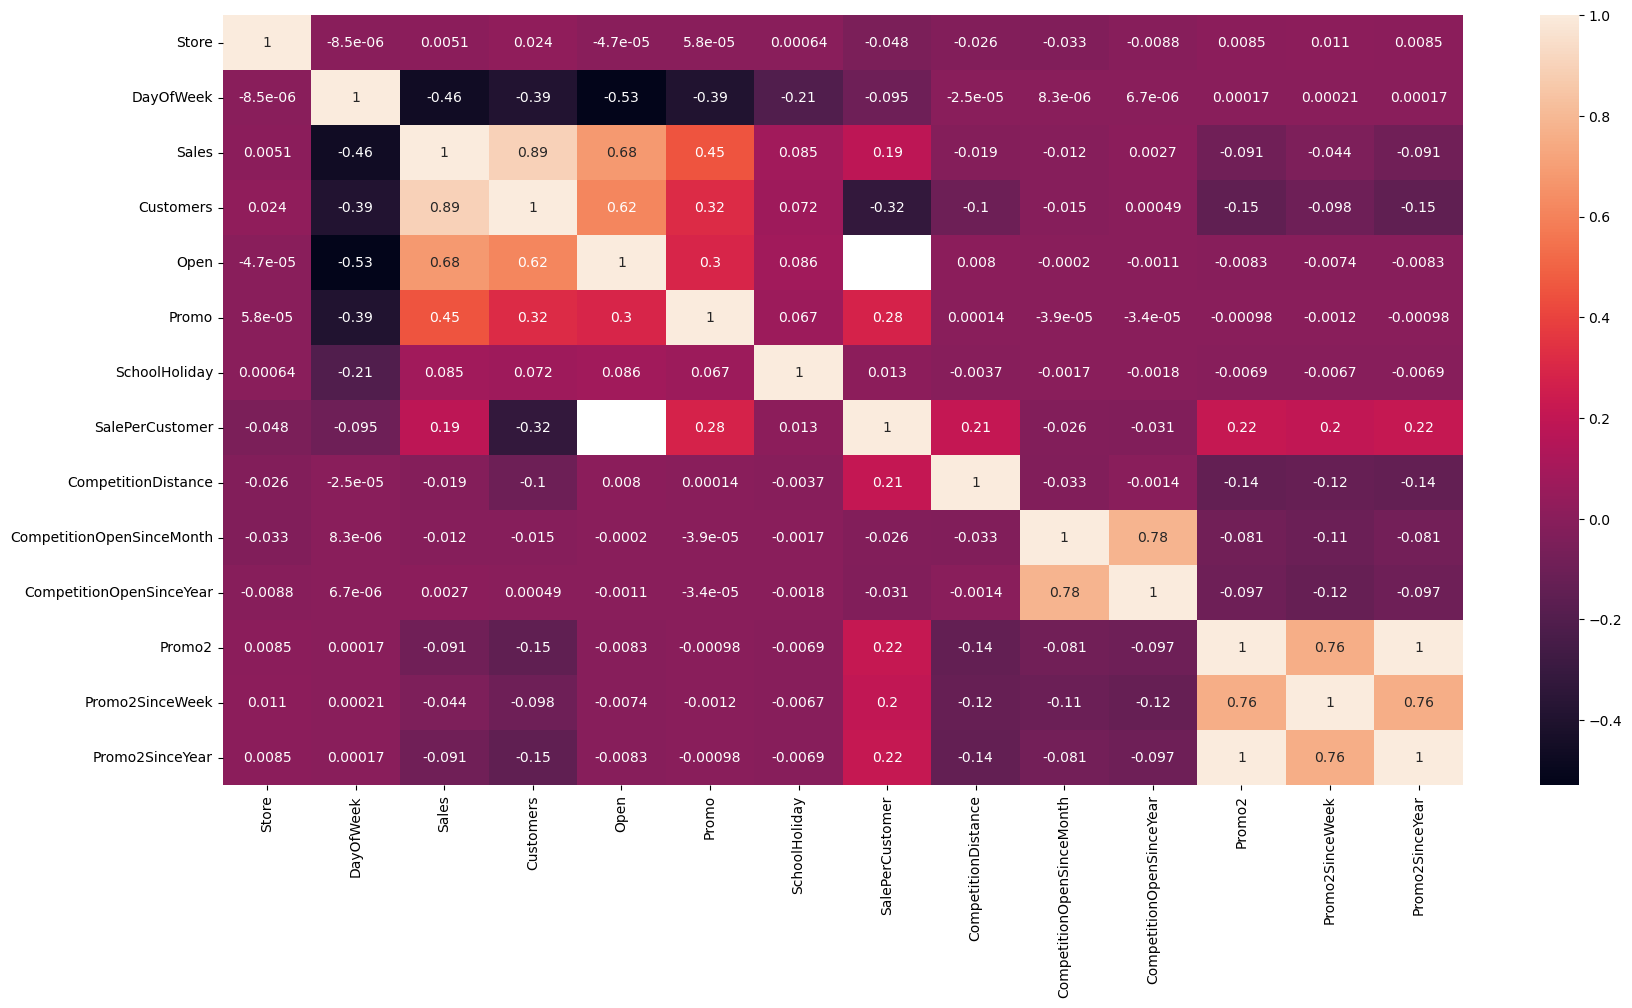

In [22]:
numeric_columns = train_store_joined.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(20, 10))
sns.heatmap(numeric_columns.corr(), annot=True)
plt.show()

- strong positive correlation between the amount of Sales and Customers visiting the store
- positive correlation between a running promotion (Promo = 1) and number of customers

#### Sales trend over the months

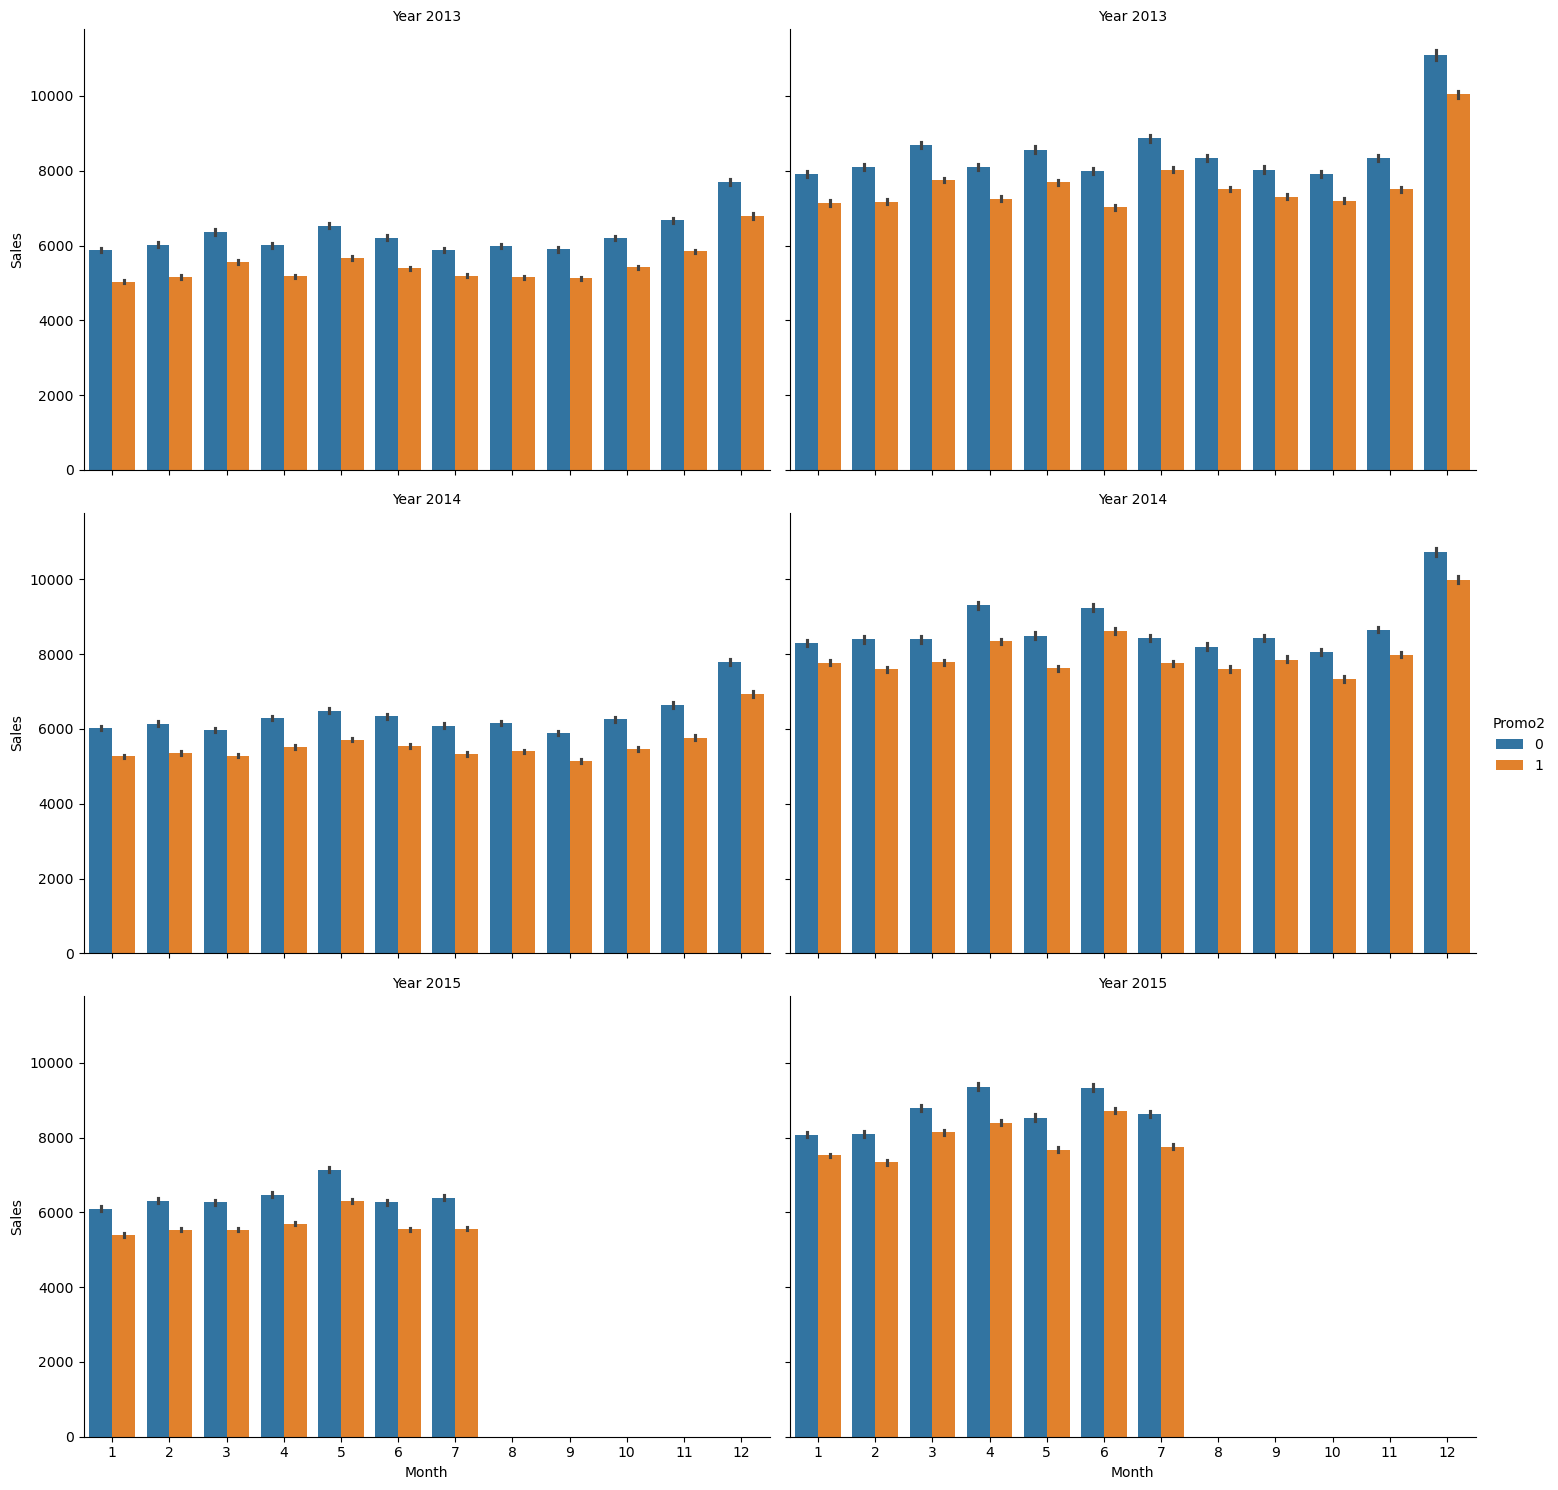

In [23]:
# Replace factorplot with catplot and specify the kind of plot
g = sns.catplot(data=train_store_joined_open,
                x="Month",
                y="Sales",
                col='Promo',
                hue='Promo2',
                row="Year",
                kind="bar",  # Specify the kind of plot here
                height=5, aspect=1.5)  # You can adjust height and aspect as needed

# Set additional plot attributes
g.set_axis_labels("Month", "Sales")
g.set_titles("Year {row_name}")

# Show the plot
plt.show()

- sales tend to spike in November and December
- seasonality factor present in data

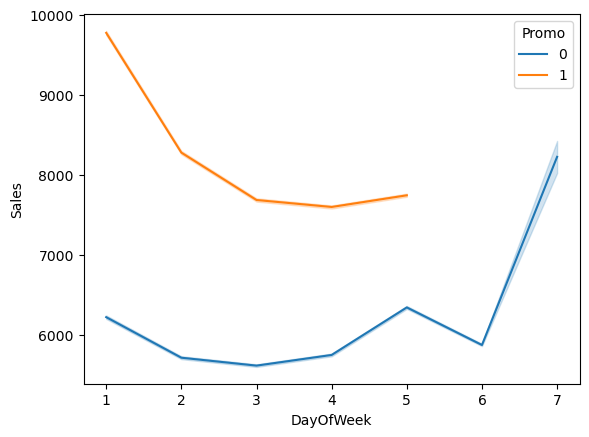

In [24]:
# Sales trend over days
sns.lineplot(data = train_store_joined_open, x = "DayOfWeek", y = "Sales", hue = "Promo");

- no promotions on the weekends i.e Saturday and Sunday (when people do their house chores)
- sales tend to increase on Sunday because people shop during the weekend
- maximum sale happens on Mondays when there are promotional offers

### Conclusions of EDA

- The most selling and crowded StoreType is A.
- StoreType B has the highest Sale per Customer.
- Customers tends to buy more on Mondays when there are ongoing promotional offers and on the Weekend when there is no promotion at all.
- Second promotion (Promo2) doesn't seem to contribute in the increase of sales. 

## Part B - Time Series Analysis & Predictive Modelling 

### Time Series Analysis

- For Time Series Anlaysis , we will consider one store from each store type **a , b , c , d** that will represent their respective group.

- It also makes sense to **downsample** the data **from days to weeks** using the resample method to see the present trends more clearly.

In [25]:
pd.plotting.register_matplotlib_converters()

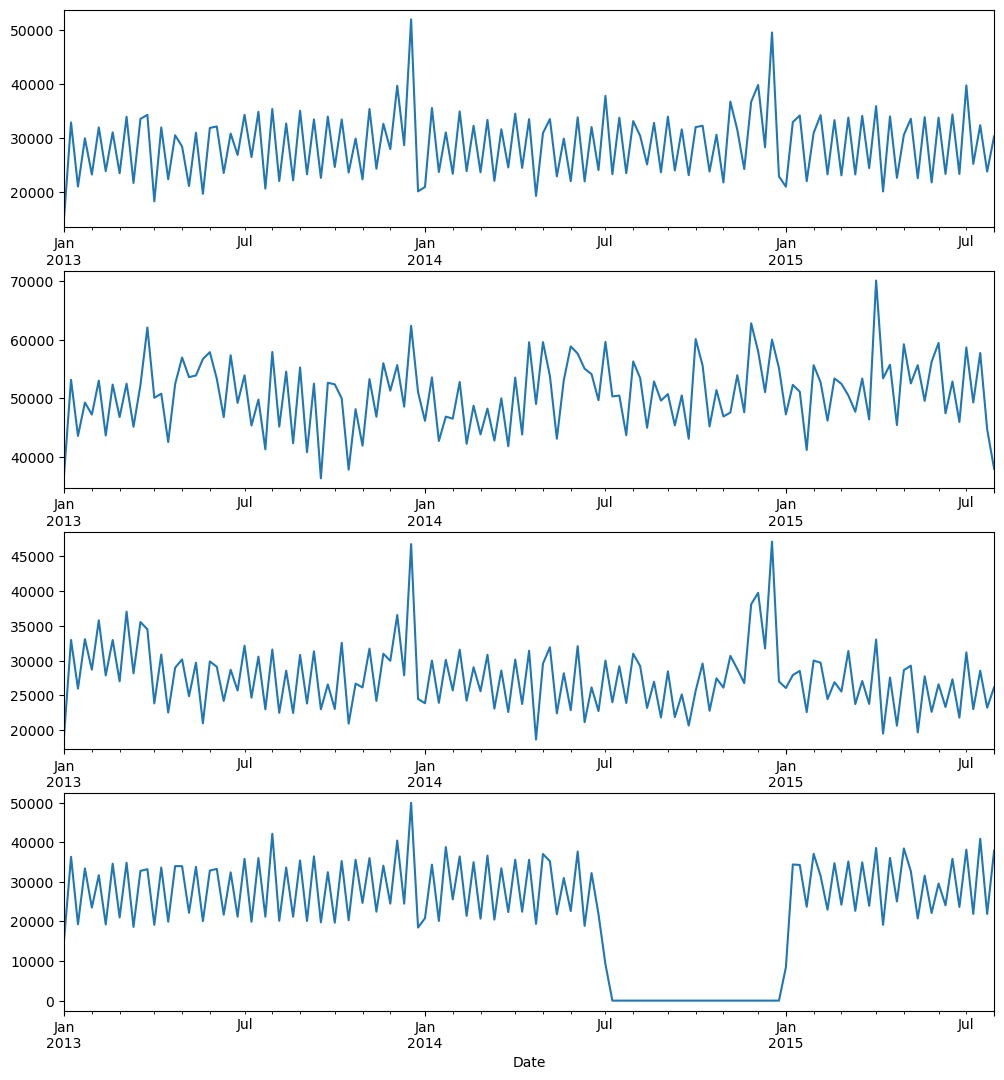

In [26]:
# Data Preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# Assigning one store from each category
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# Trend
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4);

- sales for StoreType A and C tend to peak in the end of year (Christmas season) and then decline after the holidays.
- We are not able to see a similar trend in StoreType D because no data is available for that time period (stores closed).

### Stationarity of Time Series 
- **ensure that our time series data is stationary** i.e constant mean, constant variance and constant covariance with time. 

- There are 2 ways to test the stationarity of time series <br>
        a) **Rolling Mean**: Visualization <br>
           - assess the model's stability over time.<br>
           - window is rolled (across the data) on a weekly basis, in which the average is taken on a weekly basis.<br>
           - compare the original data with the rolled data and check if the data is stationary or not.<br>
        
        b) **Dicky - Fuller test**: Statistical test <br>
            - understand whether we can reject the null hypothesis.<br>
            - The null hypothesis is that data is not stationary and the alternative hypothesis says that data is stationary.<br>
            - If p-value is less than the critical value (say 0.5), we will reject the null hypothesis and say that data is stationary.

#### check for stationarity

In [27]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)

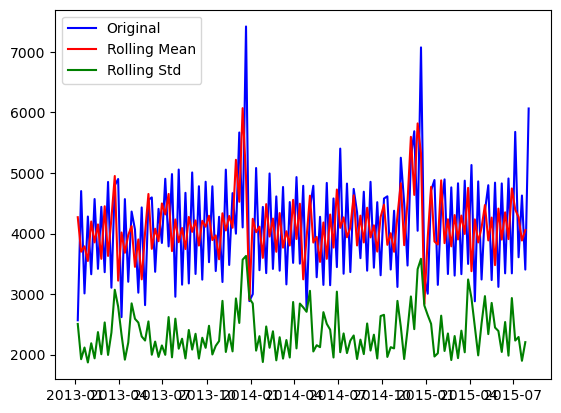

Results of Dickey-Fuller Test:
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [28]:
# Testing stationarity of store type a
test_stationarity(sales_a)

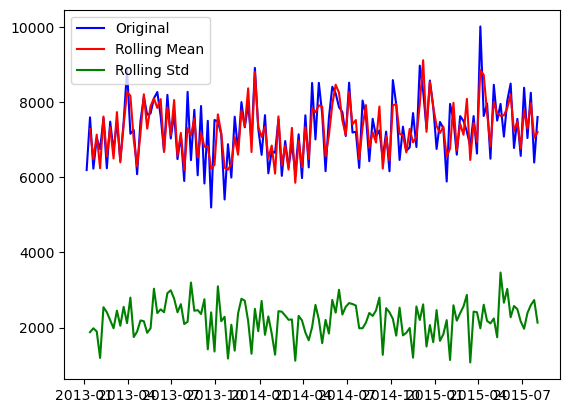

Results of Dickey-Fuller Test:
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [29]:
#Testing stationarity of store type b
test_stationarity(sales_b)

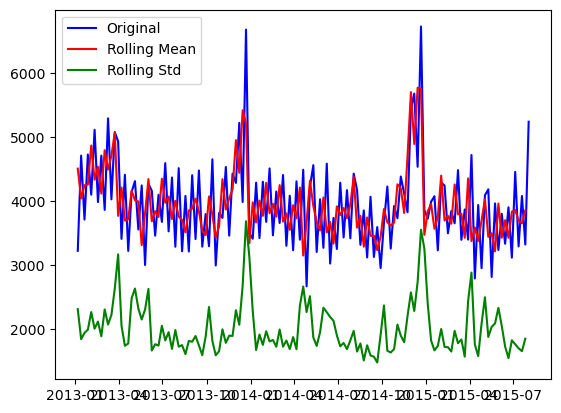

Results of Dickey-Fuller Test:
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [30]:
#Testing stationarity of store type c
test_stationarity(sales_c)

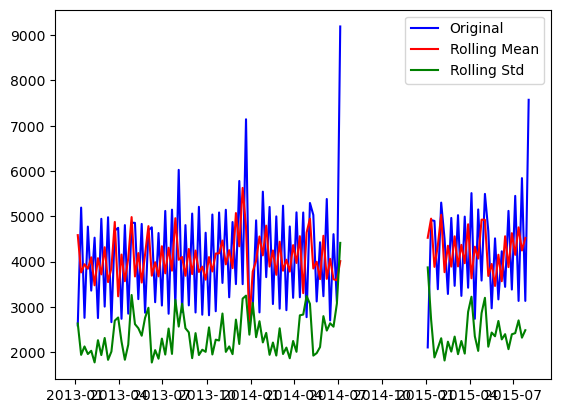

Results of Dickey-Fuller Test:
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [31]:
#Testing stationarity of store type d
test_stationarity(sales_d)

- mean and variation doesn't change much with time, i.e they are constant. Thus, we don't need to perform any transformation (needed when time series is not stationary). 

#### check for trend and seasonality

In [32]:
def plot_timeseries(sales, StoreType, frequency=365):
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(15, 10))

    decomposition = seasonal_decompose(sales, model='additive', period=frequency)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left')

    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left')

    fig.suptitle(f'Decomposition Plots for {StoreType} Store', fontsize=16)
    plt.show()

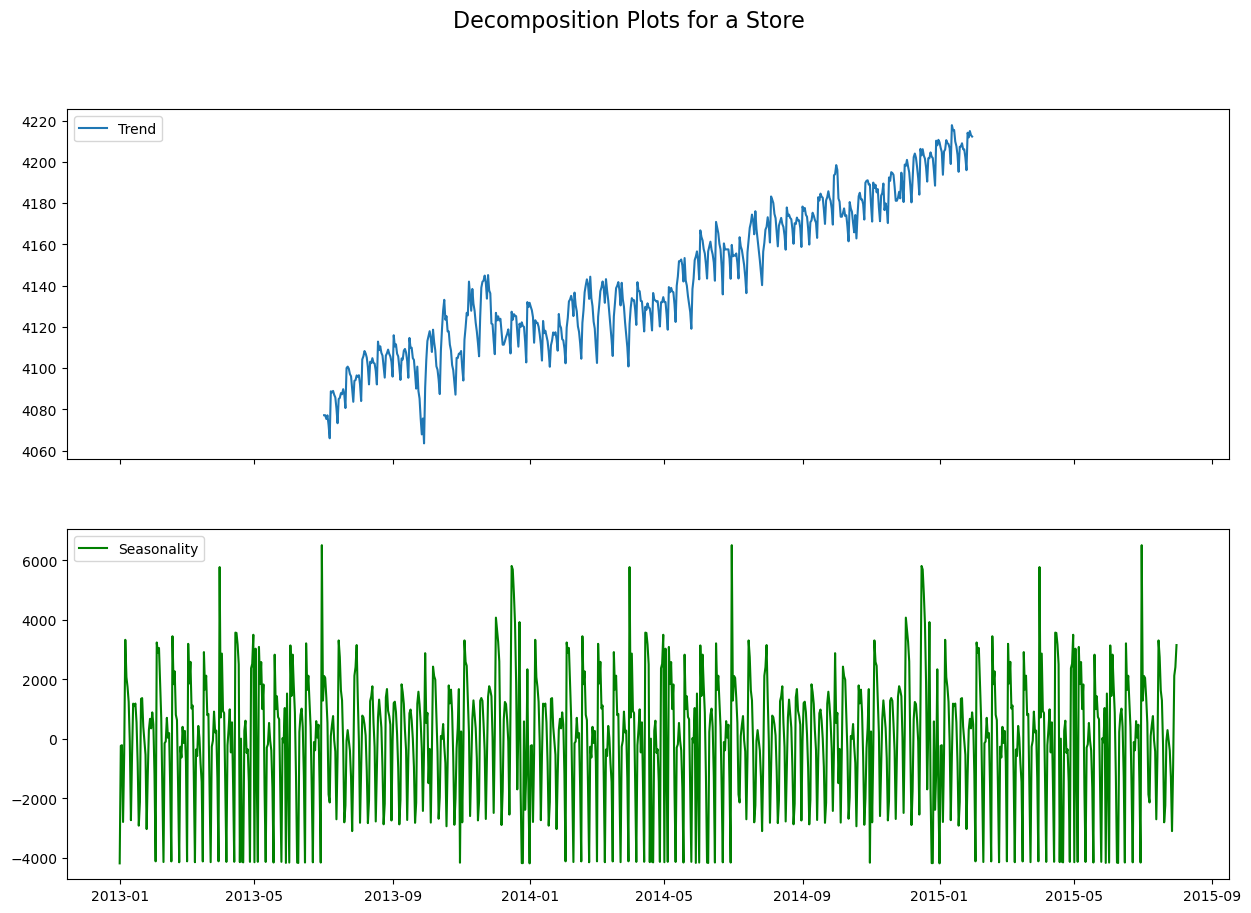

In [33]:
# Plotting seasonality and trend for store type a
plot_timeseries(sales_a,'a')

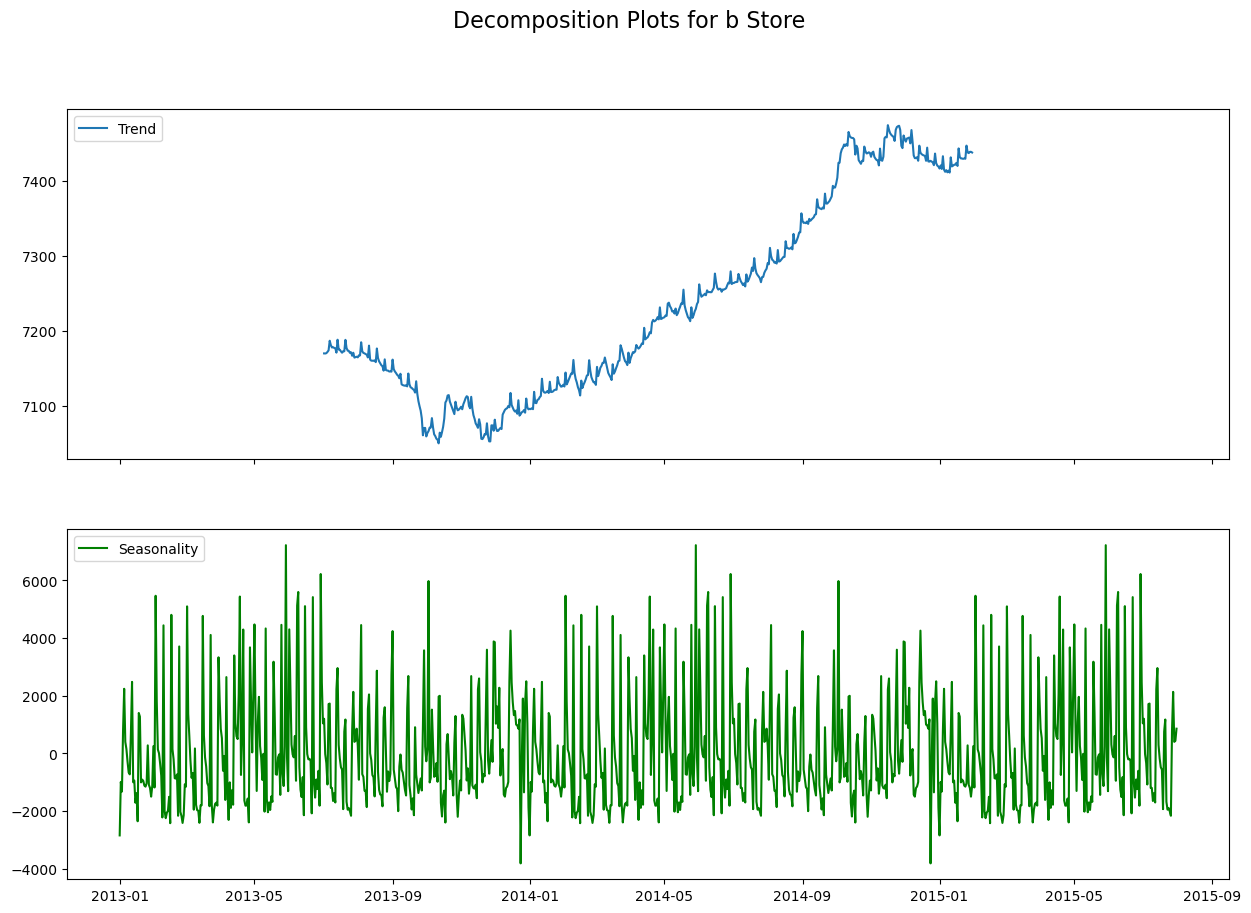

In [34]:
# Plotting seasonality and trend for store type b
plot_timeseries(sales_b,'b')

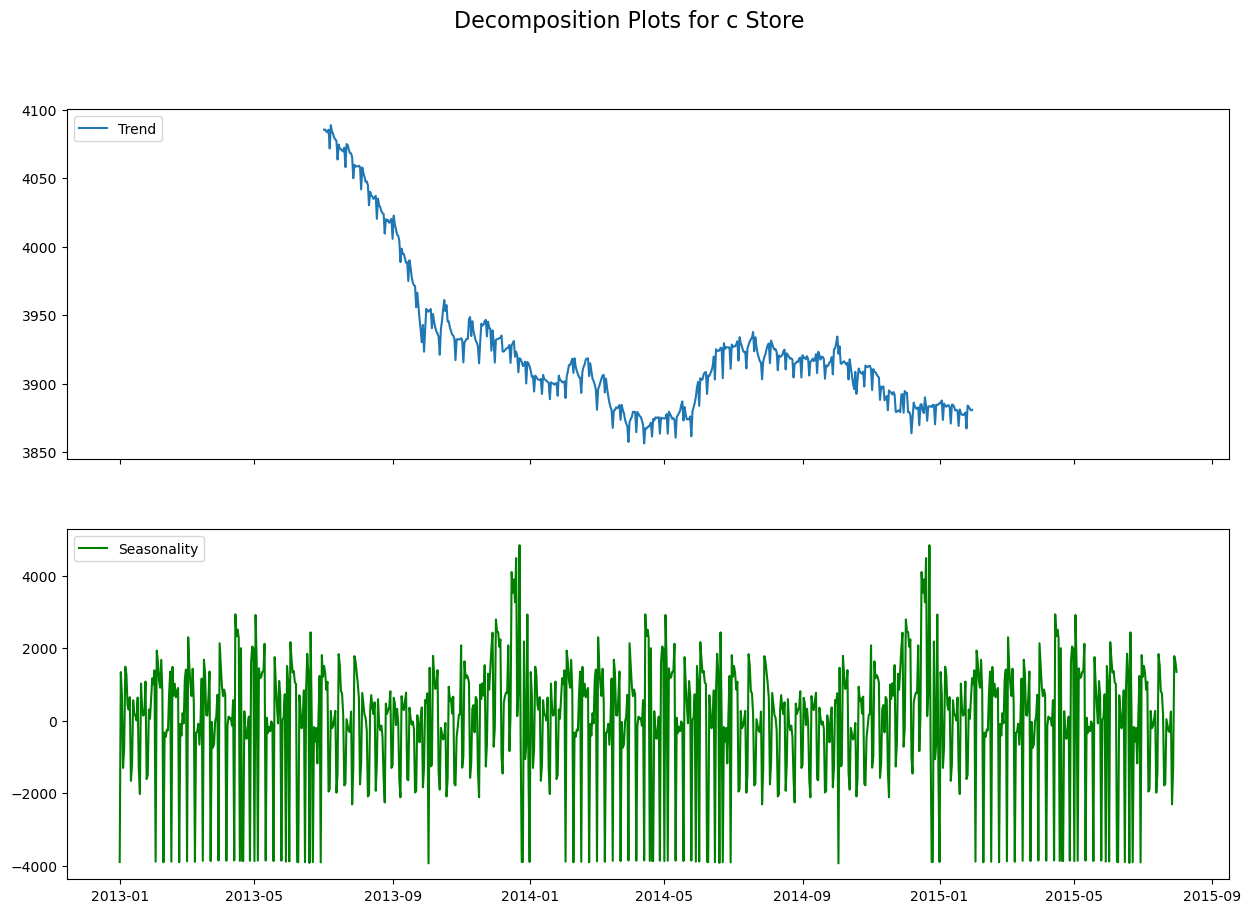

In [35]:
# Plotting seasonality and trend for store type c
plot_timeseries(sales_c,'c')

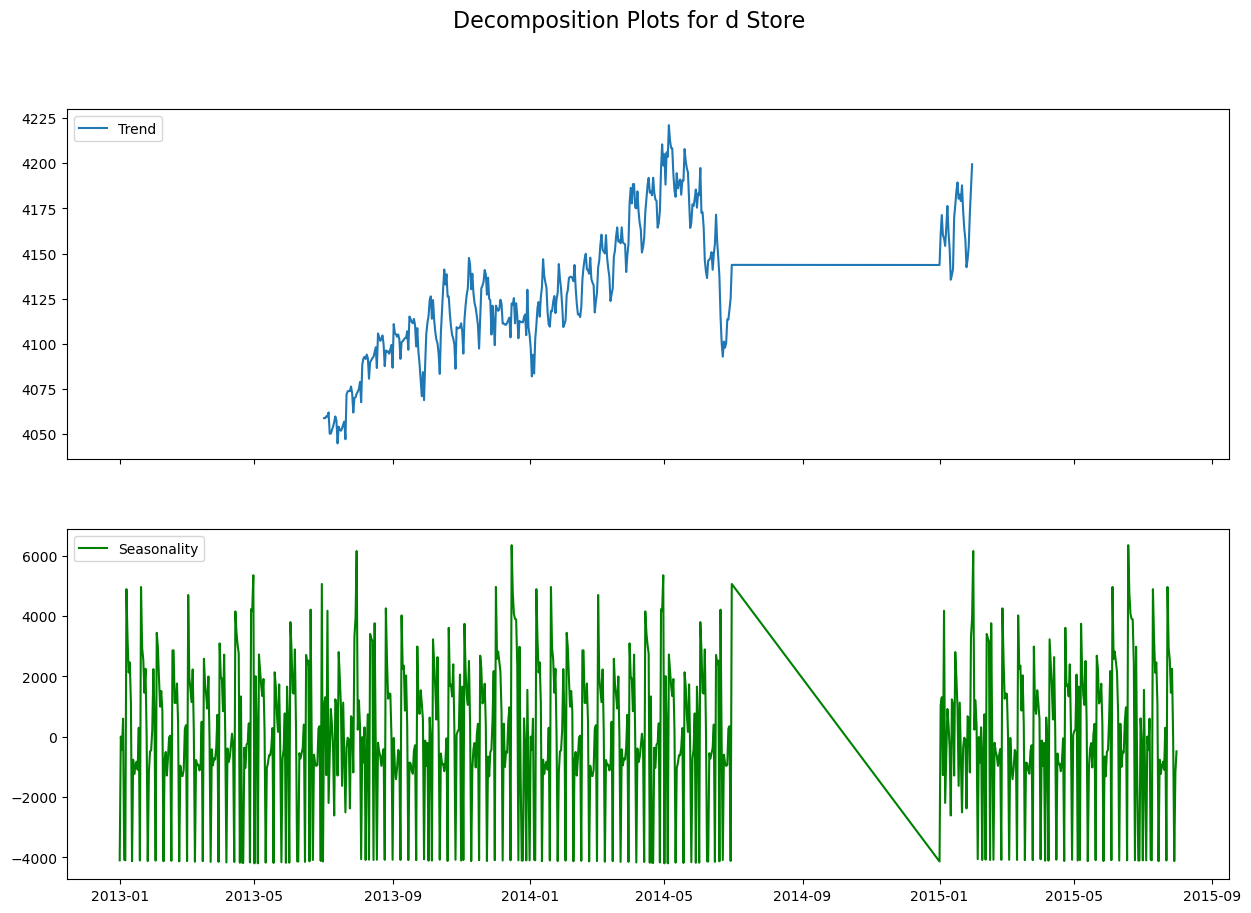

In [36]:
# Plotting seasonality and trend for store type d
plot_timeseries(sales_d,'d')

- there is seasonality and trend present in our data.
- --> use forecasting models that take both of these factors into consideration. For example, S-ARIMA and Prophet.

## Forecasting a Time Series

### Evaluation Metrics
- 2 popular metrics used in measuring the performance of regression (continuous variable) models i.e MAE & RMSE.

- **MAE - Mean Absolute Error**: It is the average of the absolute difference between the predicted values and observed values.

- **RMSE - Root Mean Square Error**: It is the square root of the average of squared differences between the predicted values and observed values.

- MAE is easier to understand and interpret but **RMSE works well in situations where large errors are undesirable**. This is because the errors are squared before they are averaged, thus penalizing large errors. In our case, RMSE suits well because we want to predict the sales with minimum error (i.e penalize high errors) so that inventory can be managed properly.

- let's choose RMSE as a metric to measure the performance of our models.

### Model 1 - SARIMA (Seasonal Autoregressive Integrated Moving Average)
- first find out values of p, d and q: 
    - **p**: number of Autoregressive terms - lags of dependent variable. p value is the value on x-axis of PACF where the plot crosses the upper Confidence Interval for the first time.
    - **q**: number of Moving Average terms - lagged forecast errors in prediction equation. q value is the value on x-axis of ACF where the plot crosses the upper Confidence Interval for the first time.

    - **d**: number of non-seasonal differences. 

- find the values of p, d and q - we use Autocorrelation function (ACF) and Partial Autocorrelation (PACF) plots.
    - **ACF** - measure of correlation between time series with a lagged version of itself.
    - **PACF** - measure of correlation between time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparison.

In [37]:
# Autocorrelation function to make ACF and PACF graphs
def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

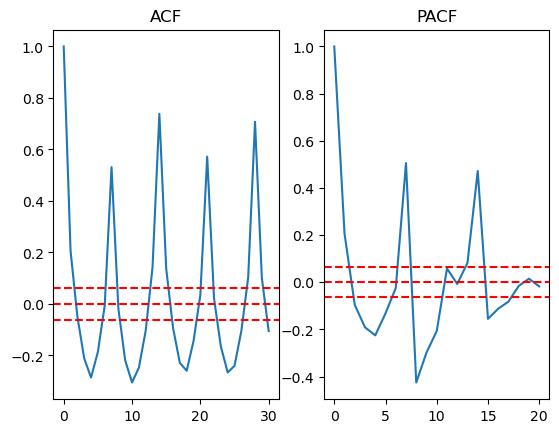

In [38]:
# ACF and PACF for store type a
auto_corr(sales_a)

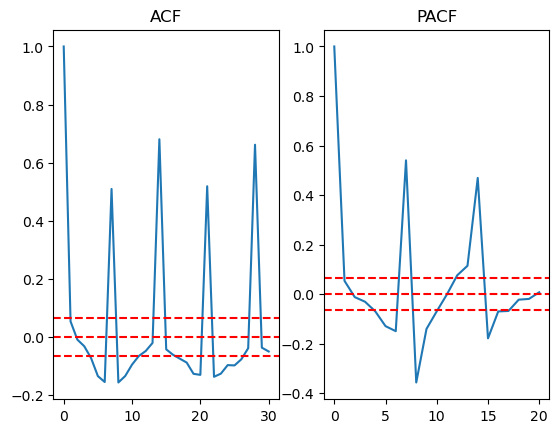

In [39]:
# ACF and PACF for store type b
auto_corr(sales_b)

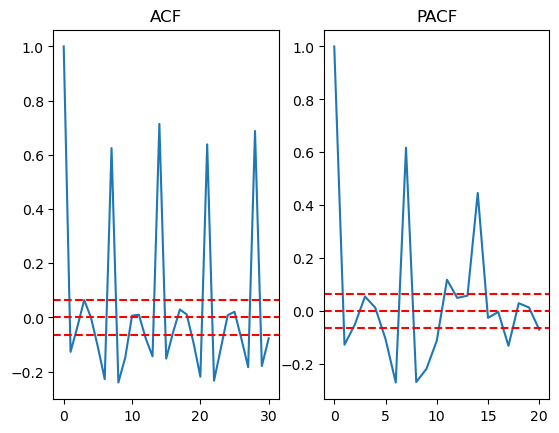

In [40]:
# ACF and PACF for store type c
auto_corr(sales_c)

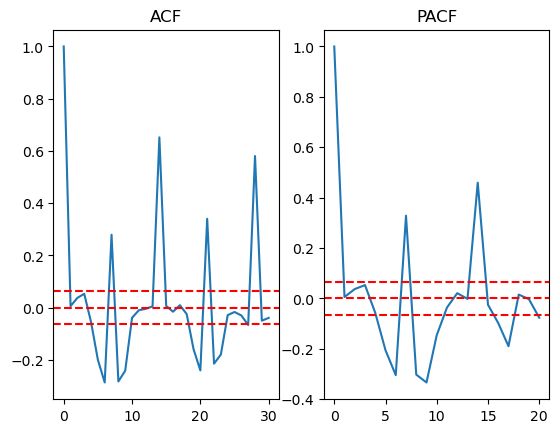

In [41]:
# ACF and PACF for store type d
auto_corr(sales_d)

- The above graphs suggest that the p = 2 and q = 2
- let's do a **grid search** and see which combination of p, q and d gives the **lowest Akaike information criterion** (AIC, which tells us the quality of statistical models for a given set of data. Best model uses the lowest number of features to fit the data.

We took one store of each category to understand the time series data but from now on, we'll use the whole dataset for modelling.

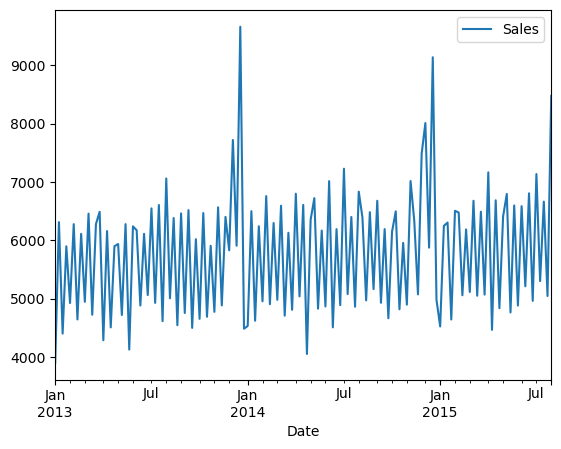

In [42]:
# Summing sales on per week basis
train_arima = train[['Sales']].resample('W').mean()
train_arima.plot();

#### Hyperparamter tuning ARIMA model 
- to choose the best combination of these parameter, we'll use a grid search.
- The best combination of parameters will give the lowest AIC score.

In [43]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Now, let's iterate through these combinations to see which one gives the lowest AIC score.

In [44]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00253D+01    |proj g|=  7.03615D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.036D-07   1.003D+01
  F =   10.025257915386275     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.03636D+00    |proj g|=  1.77335D-04

At iterate   10    f=  7.03634D+00    |proj g|=  5.64028D-03

At iterate   15    f=  7.03443D+00    |proj g|=  7.42467D-02

At iterate   20    f=  6.99947D+00    |proj g|=  2.17309D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     26      1     0     0   9.190D-07   6.999D+00
  F =   6.9993409343693269     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.8220522797183
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.00643D+00    |proj g|=  1.11178D-04

At iterate   10    f=  7.00642D+00    |proj g|=  1.14892D-03

At iterate   15    f=  7.00558D+00    |proj g|=  1.35131D-02

At iterate   20    f=  6.99638D+00    |proj g|=  2.57424D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   1.266D-05   6.996D+00
  F =   6.9961200397835830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107415675
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.74003D+00    |proj g|=  3.46257D-02

At iterate   20    f=  8.59335D+00    |proj g|=  6.54335D-01

At iterate   25    f=  8.51810D+00    |proj g|=  2.52835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     32      1     0     0   6.240D-06   8.518D+00
  F =   8.5180993722199734     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.886830499393
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.90667D+00    |proj g|=  3.84955D-03

At iterate   15    f=  6.90528D+00    |proj g|=  4.61506D-02

At iterate   20    f=  6.86877D+00    |proj g|=  1.88392D-01

At iterate   25    f=  6.85420D+00    |proj g|=  1.87169D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     28      1     0     0   1.872D-05   6.854D+00
  F =   6.8542049109873231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.6353259665773
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.62879D+00    |proj g|=  1.68748D-03

At iterate   25    f=  8.62850D+00    |proj g|=  2.37514D-02

At iterate   30    f=  8.54288D+00    |proj g|=  9.63688D-01

At iterate   35    f=  7.93448D+00    |proj g|=  4.63706D+00

At iterate   40    f=  7.69586D+00    |proj g|=  6.54303D-01

At iterate   45    f=  7.62836D+00    |proj g|=  1.12335D+00

At iterate   50    f=  7.62559D+00    |proj g|=  2.71268D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     69      1     0     0   2.713D-02   7.626D+00
  F =   7.6255876304704744     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.90735D+00    |proj g|=  1.09879D-02

At iterate   10    f=  6.90713D+00    |proj g|=  1.96542D-04

At iterate   15    f=  6.90273D+00    |proj g|=  6.03665D-02

At iterate   20    f=  6.89983D+00    |proj g|=  6.48502D-03

At iterate   25    f=  6.87629D+00    |proj g|=  1.90169D-01

At iterate   30    f=  6.83294D+00    |proj g|=  8.79872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     44      1     0     0   2.742D-05   6.833D+00
  F =   6.8329043861380176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.884184257

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  7.38142D+00    |proj g|=  4.47562D-02

At iterate   20    f=  7.31305D+00    |proj g|=  2.89416D-01

At iterate   25    f=  7.26165D+00    |proj g|=  6.75641D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     33      1     0     0   2.180D-06   7.262D+00
  F =   7.2616525511325678     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1964.6461888057934
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:2023.1445509589184
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41842D+00    |proj g|=  9.87275D-02

At iterate    5    f=  7.29373D+00    |proj g|=  3.80065D-04

At iterate   10    f=  7.29373D+00    |proj g|=  2.37864D-03

At iterate   15    f=  7.29297D+00    |proj g|=  3.24353D-02

At iterate   20    f=  7.25553D+00    |proj g|=  1.36918D-01

At iterate   25    f=  7.24385D+00    |proj g|=  2.26184D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  7.44409D+00    |proj g|=  5.75938D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     36      1     0     0   5.225D-06   7.444D+00
  F =   7.4440889857131110     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2015.90402614254
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97390D+00    |proj g|=  4.80230D-01

At iterate    5    f=  7.88698D+00    |proj g|=  1.94882D-02

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.99318D+00    |proj g|=  4.36828D-03

At iterate   15    f=  6.99188D+00    |proj g|=  8.96731D-02

At iterate   20    f=  6.84285D+00    |proj g|=  2.26797D-01

At iterate   25    f=  6.78458D+00    |proj g|=  1.54006D-01

At iterate   30    f=  6.77952D+00    |proj g|=  8.53229D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     39      1     0     0   8.532D-06   6.780D+00
  F =   6.7795153883874377     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:1836.4691548646083
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.49477D+00    |proj g|=  5.03705D-02

At iterate   15    f=  7.49440D+00    |proj g|=  3.67238D-04

At iterate   20    f=  7.49433D+00    |proj g|=  4.50465D-03

At iterate   25    f=  7.49038D+00    |proj g|=  4.15604D-02

At iterate   30    f=  7.44229D+00    |proj g|=  4.51961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     38      1     0     0   6.000D-06   7.442D+00
  F =   7.4422605197217715     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2017.4103403248782
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  7.16788D+00    |proj g|=  1.86817D-02

At iterate   10    f=  7.16779D+00    |proj g|=  9.31686D-04

At iterate   15    f=  7.16743D+00    |proj g|=  2.54788D-02

At iterate   20    f=  7.14481D+00    |proj g|=  3.24616D-01

At iterate   25    f=  7.05966D+00    |proj g|=  1.50655D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     37      1     0     0   2.371D-07   7.060D+00
  F =   7.0596531717490798     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:1912.1063563722516
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.


At iterate   10    f=  6.99155D+00    |proj g|=  6.32186D-03

At iterate   15    f=  6.99145D+00    |proj g|=  4.72419D-04

At iterate   20    f=  6.99142D+00    |proj g|=  9.84465D-03

At iterate   25    f=  6.98659D+00    |proj g|=  1.35920D-01

At iterate   30    f=  6.82802D+00    |proj g|=  2.14631D-01

At iterate   35    f=  6.77422D+00    |proj g|=  3.53244D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     51      1     0     0   1.733D-06   6.774D+00
  F =   6.7742168082302658     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1837.0385382221

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.02642D+00    |proj g|=  1.92692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   9.459D-06   8.026D+00
  F =   8.0264175771008279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2173.1327458172236
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77047D+00    |proj g|=  6.50475D-06

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   4.366D-05   8.021D+00
  F =   8.0207865652389660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:2173.6123726145206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92042D+00    |proj g|=  1.83538D-02

At iterate    5    f=  6.92005D+00    |proj g|=  1.57510D-03

At iterate   10    f=  6.91960D+00    |proj g|=  2.47541D-02

At iterate   

 This problem is unconstrained.



At iterate   20    f=  6.89339D+00    |proj g|=  3.33180D-02

At iterate   25    f=  6.88342D+00    |proj g|=  1.75606D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     35      1     0     0   1.501D-05   6.883D+00
  F =   6.8831057706458170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1866.4385580743706
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46944D+00    |proj g|=  2.06548D+01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.59973D+00    |proj g|=  1.84847D+00

At iterate   10    f=  7.55798D+00    |proj g|=  2.86515D+00

At iterate   15    f=  7.55686D+00    |proj g|=  1.17717D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     58      2     0     0   1.177D-02   7.557D+00
  F =   7.5568571322889850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2048.351425718026
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.68595D+00    |proj g|=  2.84555D-02

At iterate    5    f=  7.68577D+00    |proj g|=  2.26768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     55      1     0     0   4.332D-02   7.620D+00
  F =   7.6195652019051368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:2065.282604514387
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67831D+00    |proj g|=  4.87710D-01

At iterate    5    f=  7.62440D+00    |proj g|=  2.49697D-01

At iterate   10    f=  7.59237D+00    |proj g|=  1.50367D-01

At iterate   1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  7.56433D+00    |proj g|=  8.63740D-02

At iterate   25    f=  7.55675D+00    |proj g|=  6.40779D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     82      2     0     0   2.657D-03   7.557D+00
  F =   7.5567156731134624     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2050.313231740635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90360D+00    |proj g|=  3.11980D-02

At iterate    5    f=  6.90291D+00    |proj g|=  1.15457D-03

At iterate   10    f=  6.90291D+00    |proj g|=  1.41205D-03

At iterate   1

 This problem is unconstrained.



At iterate   10    f=  6.82473D+00    |proj g|=  1.89332D-04

At iterate   15    f=  6.82468D+00    |proj g|=  5.31960D-03

At iterate   20    f=  6.82022D+00    |proj g|=  8.24560D-02

At iterate   25    f=  6.79835D+00    |proj g|=  1.06015D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     32      1     0     0   4.948D-05   6.798D+00
  F =   6.7981409545103828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1845.4980577178035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   1.415D-05   7.856D+00
  F =   7.8564580252301717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2125.2436668121463
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93186D+00    |proj g|=  1.49642D-01

At iterate    5    f=  6.91182D+00    |proj g|=  2.38098D-04

At iterate   10    f=  6.91181D+00    |proj g|=  4.58049D-03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00064D+00    |proj g|=  7.56974D-02

At iterate    5    f=  6.99733D+00    |proj g|=  2.15363D-04

At iterate   10    f=  6.99730D+00    |proj g|=  6.05172D-03

At iterate   15    f=  6.99453D+00    |proj g|=  5.79801D-02

At iterate   20    f=  6.98818D+00    |proj g|=  2.07120D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   3.763D-06   6.988D+00
  F =   6.9881756054761643     

CONVERG

 This problem is unconstrained.



At iterate   15    f=  6.90835D+00    |proj g|=  6.33082D-03

At iterate   20    f=  6.90458D+00    |proj g|=  7.40653D-02

At iterate   25    f=  6.83492D+00    |proj g|=  6.13722D-02

At iterate   30    f=  6.83138D+00    |proj g|=  3.55893D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     36      1     0     0   3.559D-06   6.831D+00
  F =   6.8313807424497890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1852.472800461443
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.03848D+00    |proj g|=  1.12979D-02
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:2176.3777229676543

At iterate   10    f=  8.03844D+00    |proj g|=  1.22052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   1.221D-04   8.038D+00
  F =   8.0384360109913118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34364D+00    |proj g|=  1.27710D-01

At iterate   

 This problem is unconstrained.



At iterate    5    f=  6.75939D+00    |proj g|=  3.75184D-03

At iterate   10    f=  6.75937D+00    |proj g|=  6.65517D-04

At iterate   15    f=  6.75929D+00    |proj g|=  1.25665D-02

At iterate   20    f=  6.74866D+00    |proj g|=  1.65250D-01

At iterate   25    f=  6.66927D+00    |proj g|=  6.47285D-02

At iterate   30    f=  6.66036D+00    |proj g|=  2.27966D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     35      1     0     0   1.640D-06   6.660D+00
  F =   6.6603636691502039     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1806.298190670

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34420D+00    |proj g|=  1.25730D-01

At iterate    5    f=  7.31440D+00    |proj g|=  4.42801D-02

At iterate   10    f=  7.30694D+00    |proj g|=  2.57385D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   9.548D-05   7.307D+00
  F =   7.3069339953101089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1982.8721787337295
RUNNING THE L-

 This problem is unconstrained.



At iterate   10    f=  6.89669D+00    |proj g|=  6.68822D-04

At iterate   15    f=  6.89632D+00    |proj g|=  1.93136D-03

At iterate   20    f=  6.89088D+00    |proj g|=  6.18410D-02

At iterate   25    f=  6.87132D+00    |proj g|=  5.32070D-03

At iterate   30    f=  6.87127D+00    |proj g|=  1.12088D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     41      1     0     0   1.121D-07   6.871D+00
  F =   6.8712720472180067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:1863.2434527488617
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  6.75837D+00    |proj g|=  3.27961D-02

At iterate   10    f=  6.75654D+00    |proj g|=  3.67519D-04

At iterate   15    f=  6.75653D+00    |proj g|=  1.71457D-03

At iterate   20    f=  6.75499D+00    |proj g|=  2.96719D-02

At iterate   25    f=  6.65882D+00    |proj g|=  5.07760D-02

At iterate   30    f=  6.65686D+00    |proj g|=  4.76870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     40      1     0     0   1.599D-05   6.657D+00
  F =   6.6568479290512830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1807.348940843

We can see from the above grid search that our optimal parameter combination is ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1806.2981906705384. So, let's use this in our model.


#### Fitting the model - using hyperparamters tuned above

In [45]:
# Fitting the data to SARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_sarima = model_sarima.fit()

print(results_sarima.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.78887D+00    |proj g|=  1.47334D-01

At iterate    5    f=  6.75939D+00    |proj g|=  3.75184D-03

At iterate   10    f=  6.75937D+00    |proj g|=  6.65517D-04

At iterate   15    f=  6.75929D+00    |proj g|=  1.25665D-02


 This problem is unconstrained.



At iterate   20    f=  6.74866D+00    |proj g|=  1.65250D-01

At iterate   25    f=  6.66927D+00    |proj g|=  6.47285D-02

At iterate   30    f=  6.66036D+00    |proj g|=  2.27966D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     35      1     0     0   1.640D-06   6.660D+00
  F =   6.6603636691502039     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5251      0.103     -5.091      0.000      -0.727      -0.323


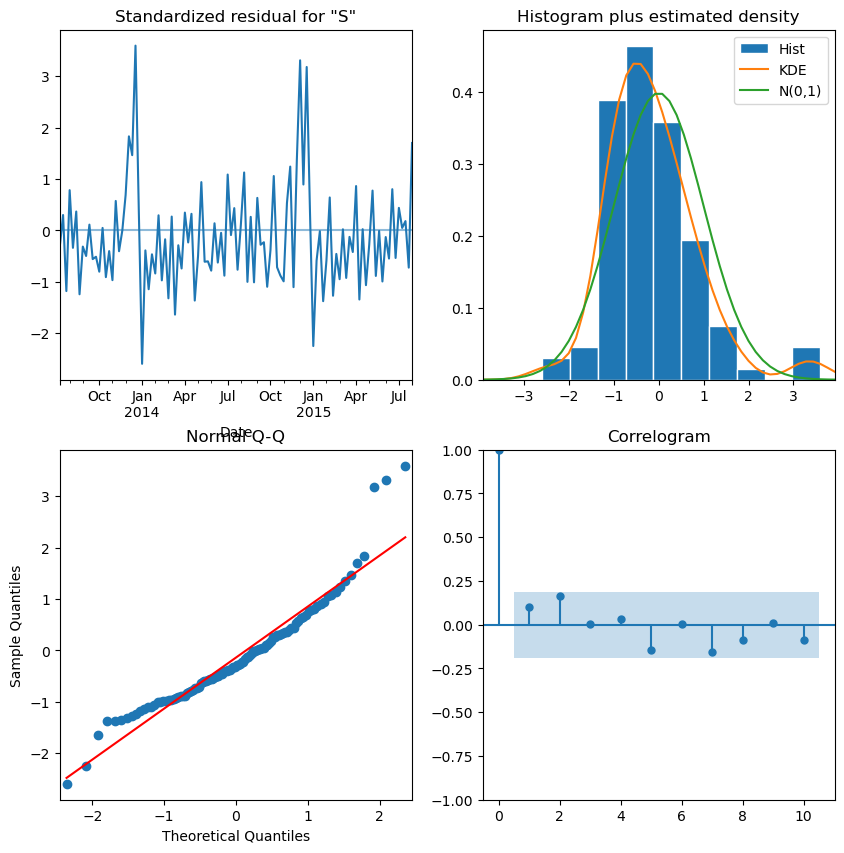

In [46]:
# Checking diagnostic plots
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

- We can see from the above 'Histogram plus estimated density' plot that our KDE (Kernel Desnity Estimator) plot closely follows the N(0,1) normal distribution plot.
- The Normal Q-Q plot shows that the ordered distribution of residuals follows the distribution similar to normal distribution. Thus, our model seems to be pretty good.

Standardized residual plot tells us that there is no major seasonality trend, which is confirmed by Correlogram (autocorrelation) plot. Autocorrelation plot tells us that the time series residuals have low correlation with lagged versions of itself.

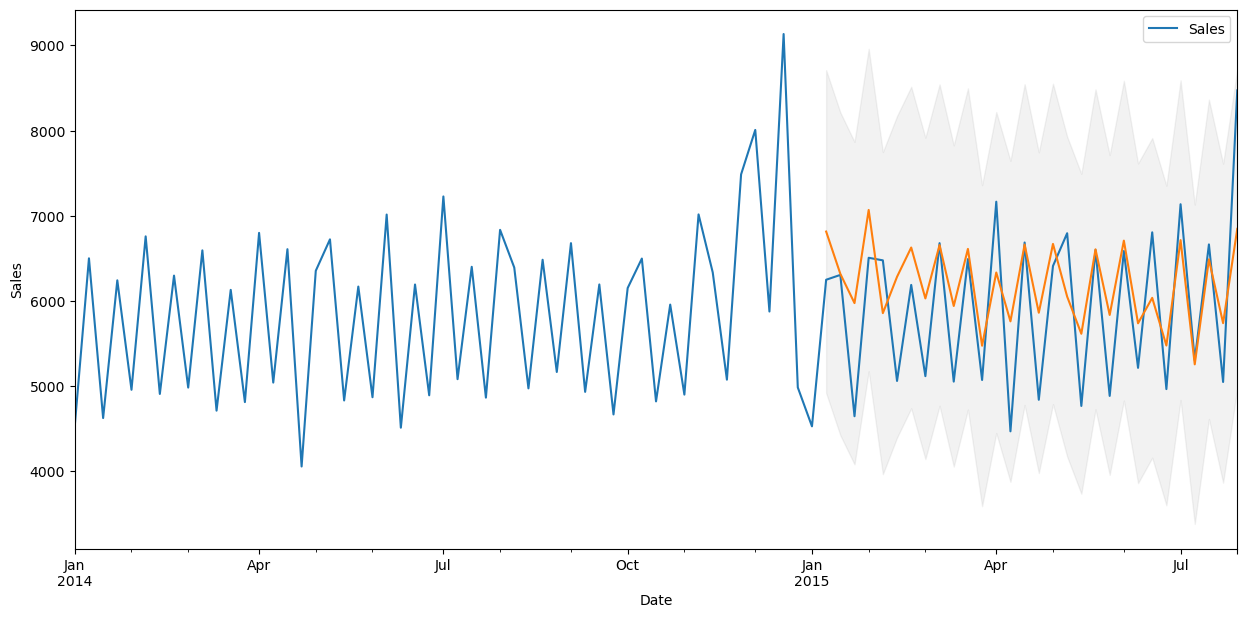

Root Mean Squared Error:  739.0611673647138


In [47]:
# Model Prediction and validation 
# Predictions are performed for the 11th Jan' 2015 onwards of the train data.

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-01-11'), dynamic = False) 

# Get confidence intervals of forecasts
pred_ci = pred.conf_int() 

ax = train_arima["2014":].plot(label = "observed", figsize=(15, 7))
pred.predicted_mean.plot(ax = ax, label = "One-step ahead Forecast", alpha = 1)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color = "k", alpha = 0.05)

ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.legend
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima["2015-01-11":]

# Calculating the error
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

### Final ARIMA Solution:  
We tried different combinations of parameters using Grid search and foundoptimal parameter: ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1806.29. Let's try another model to see if we can reduce the error.

## Model 2 - Prophet

In [110]:
# Creating a train dataset
train_prophet = train.copy()
train_prophet.reset_index(level=0, inplace=True)

In [111]:
# Converting col names to specific names as required by Prophet library
train_prophet = train_prophet.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
#train_prophet['ds'] = pd.to_datetime(train_prophet['ds'])

In [112]:
# Downsampling to week because modelling on daily basis takes a lot of time
#ts_step_week_prophet = train_prophet.set_index("ds")
ts_step_week_prophet.head()

,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
ds,,,,,,,,,,,,,
2015-07-31,1,5,5263.0,555,1,1,0.0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064.0,625,1,1,0.0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314.0,821,1,1,0.0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995.0,1498,1,1,0.0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822.0,559,1,1,0.0,1,2015,7,31,31,8.626118


In [115]:
# Convert non-numeric values to numeric, leaving non-convertible values as NaN
ts_step_week_prophet = ts_step_week_prophet.apply(pd.to_numeric, errors='coerce')

# Resample the DataFrame by week and sum the numeric values for each week
ts_week_prophet = ts_step_week_prophet.resample('W').sum()

ts_week_prophet.reset_index(inplace=True)
ts_week_prophet.head()

,ds,Store,DayOfWeek,y,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
0,2013-01-06,3732032,30103,26129335.0,3110602,4471,0,0.0,4533,13464957,6689,23414,6689,39406.143319
1,2013-01-13,4355190,31220,49275222.0,5226350,6649,5575,0.0,560,15711465,7805,78050,15610,65076.326540
2,2013-01-20,4355190,31220,34377765.0,4205743,6654,0,0.0,0,15711465,7805,132685,23415,57208.229656
3,2013-01-27,4355190,31220,46040169.0,4928833,6665,5575,0.0,0,15711465,7805,187320,31220,65073.831993
4,2013-02-03,4355190,31220,38466029.0,4507650,6667,0,0.0,128,15711465,11150,138260,39025,59686.174407


#### Initial/Baseline Prophet Model

In [117]:
# Fitting data to Prophet model
prophet_1 = Prophet() 
prophet_1.fit(ts_week_prophet)

future_1 = prophet_1.make_future_dataframe(periods = 52, freq = "W") 
forecast_1 = prophet_1.predict(future_1)

forecast_1[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail() 

16:51:17 - cmdstanpy - INFO - Chain [1] start processing
16:51:17 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.445909e+07,3.443256e+07,5.311809e+07
183,2016-07-10,4.410669e+07,3.381393e+07,5.325619e+07
184,2016-07-17,4.435011e+07,3.466503e+07,5.401042e+07
185,2016-07-24,4.423756e+07,3.474774e+07,5.373341e+07
186,2016-07-31,4.344612e+07,3.422118e+07,5.309779e+07


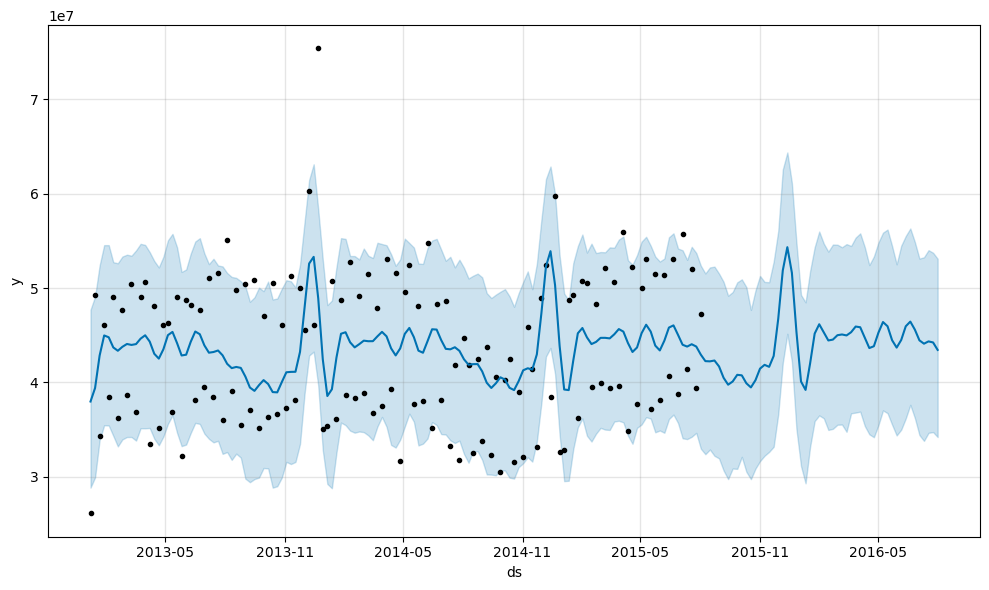

In [120]:
# Visualizing predicions of forecast
prophet_1.plot(forecast_1);

In [122]:
# Checking the RMSE of Prophet model
metric_prophet_1 = forecast_1.set_index('ds')[['yhat']].join(ts_week_prophet.set_index('ds').y).reset_index()
metric_prophet_1.dropna(inplace=True)
rms_prophet_1 = mean_squared_error(metric_prophet_1.y, metric_prophet_1.yhat)
rms_prophet_1

53783140657538.04

Now let's try to reduce this error.

### Hypertuning Prophet model
There are a lot of parameters available in the Prophet model. One of the most important ones is 'holidays'. This lets us pass holidays explicitly while training the model. We'll create a new 'holidays' data frame by taking observations when there was school or state holiday.

We'll also use three more parameters viz.

- interval_width: It defines the uncertainty level to make the prediction. The default value is 0.8 but we'll take 0.95 because we want to be certain in our predictions.
- growth: We know that 'Sales' can take any value and there is no saturation point. So, we'll take 'linear' growth instead of 'logarithmic'.
- yearly_seasonality: We'll explicitly pass it as 'True' because we know that there is a yearly seasonality (discussed above) present in our data.

In [123]:
# Encoding state holiday categorical variable
train_prophet["StateHoliday_cat"] = train_prophet["StateHoliday"].map({0:0, "0": 0, "a": 1, "b": 1, "c": 1})

In [124]:
# Choosing only required cols
train_prophet = train_prophet[['ds', 'y', 'SchoolHoliday', 'StateHoliday_cat']]
train_prophet.head()

,ds,y,SchoolHoliday,StateHoliday_cat
0,2015-07-31,5263.0,1,0
1,2015-07-31,6064.0,1,0
2,2015-07-31,8314.0,1,0
3,2015-07-31,13995.0,1,0
4,2015-07-31,4822.0,1,0


In [125]:
# Modelling holidays - creating holidays dataframe
state_dates = train_prophet[(train_prophet.StateHoliday_cat == 1)].loc[:, "ds"].values
school_dates = train_prophet[(train_prophet.SchoolHoliday == 1)].loc[:, "ds"].values

state = pd.DataFrame({"holiday": "state_holiday",  "ds": pd.to_datetime(state_dates)})
school = pd.DataFrame({"holiday": "school_holiday", "ds": pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [126]:
# Dropping holiday columns because not needed any more
train_prophet_clean = train_prophet.drop(["SchoolHoliday", "StateHoliday_cat"], axis = 1)
train_prophet_clean.head()

,ds,y
0,2015-07-31,5263.0
1,2015-07-31,6064.0
2,2015-07-31,8314.0
3,2015-07-31,13995.0
4,2015-07-31,4822.0


In [127]:
# Downsampling to week because modelling on daily basis takes a lot of time
ts_week_prophet = train_prophet_clean.set_index("ds").resample("W").sum()
ts_week_prophet.head()

,y
ds,
2013-01-06,26129335.0
2013-01-13,49275222.0
2013-01-20,34377765.0
2013-01-27,46040169.0
2013-02-03,38466029.0


In [128]:
# Resetting the index
ts_week_prophet_train = ts_week_prophet.reset_index()
ts_week_prophet_train.head()

,ds,y
0,2013-01-06,26129335.0
1,2013-01-13,49275222.0
2,2013-01-20,34377765.0
3,2013-01-27,46040169.0
4,2013-02-03,38466029.0


In [131]:
# Fitting data to Prophet model
prophet_2 = Prophet(holidays = holidays, interval_width = 0.95, growth='linear', yearly_seasonality = True) 
prophet_2.fit(ts_week_prophet_train)
print("done")

future_2 = prophet_2.make_future_dataframe(periods = 52, freq = "W") 
forecast_2 = prophet_2.predict(future_2)

forecast_2[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail() # We have a new dataframe, which includes, the forecast and the uncertainity invervals.

17:03:43 - cmdstanpy - INFO - Chain [1] start processing
17:03:43 - cmdstanpy - INFO - Chain [1] done processing


done


,ds,yhat,yhat_lower,yhat_upper
182,2016-07-03,4.414500e+07,3.105268e+07,5.787391e+07
183,2016-07-10,4.383957e+07,2.928988e+07,5.800107e+07
184,2016-07-17,4.410862e+07,3.015099e+07,5.776316e+07
185,2016-07-24,4.412177e+07,2.994830e+07,5.718050e+07
186,2016-07-31,4.352340e+07,2.864072e+07,5.797892e+07


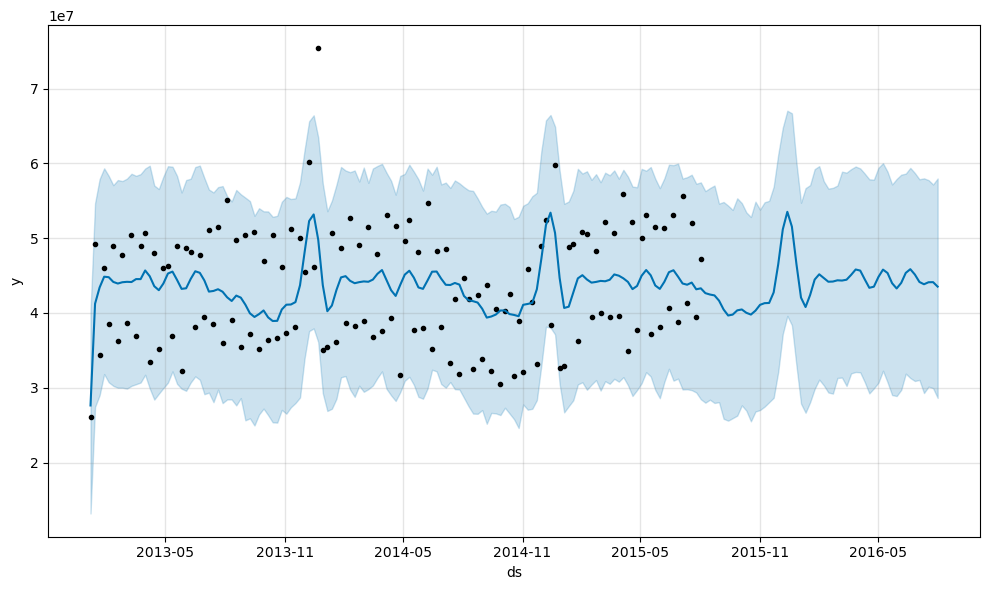

In [133]:
# Visualizing predicions of forecast
prophet_2.plot(forecast_2);

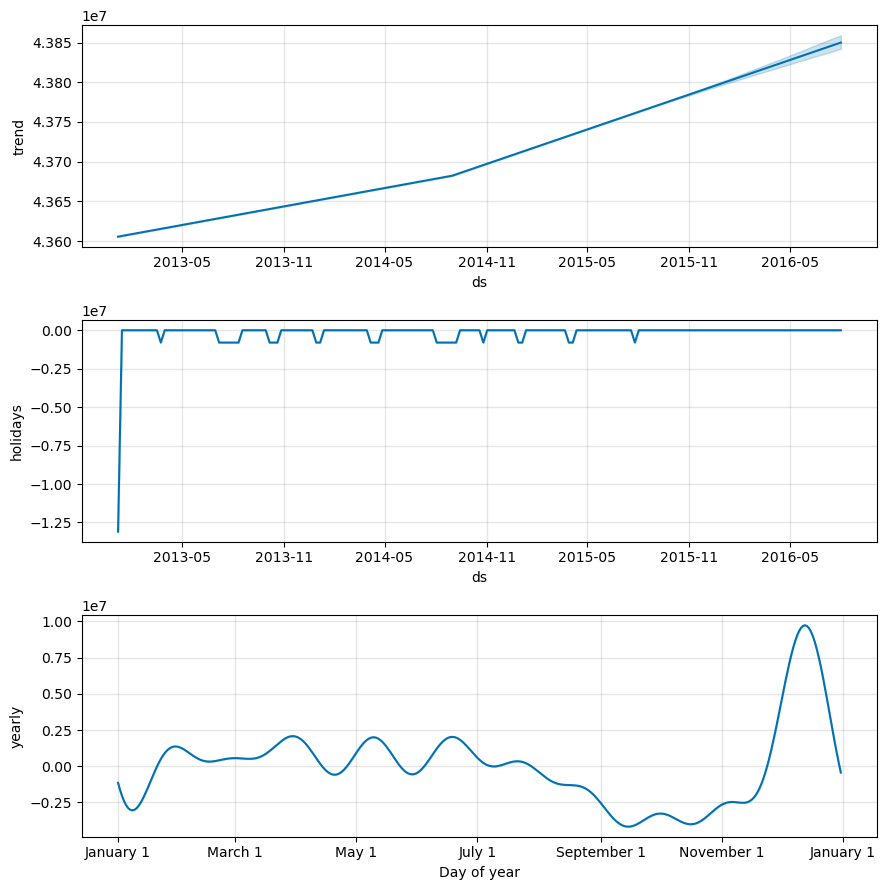

In [134]:
# Visualizing trend and seasonality components
prophet_2.plot_components(forecast_2);

The first plot shows that the total sales on a weekly basis are increasing. The second plot shows the holiday gaps in the dataset and the third plot shows that the store sees very high sales in the last week of December (because of the Christmas holidays).

In [136]:
# Checking the RMSE of Prophet model
metric_prophet_2 = forecast_2.set_index('ds')[['yhat']].join(ts_week_prophet_train.set_index('ds').y).reset_index()
metric_prophet_2.dropna(inplace=True)
rms_prophet_2 = mean_squared_error(metric_prophet_2.y, metric_prophet_2.yhat)
rms_prophet_2

52478275861356.875

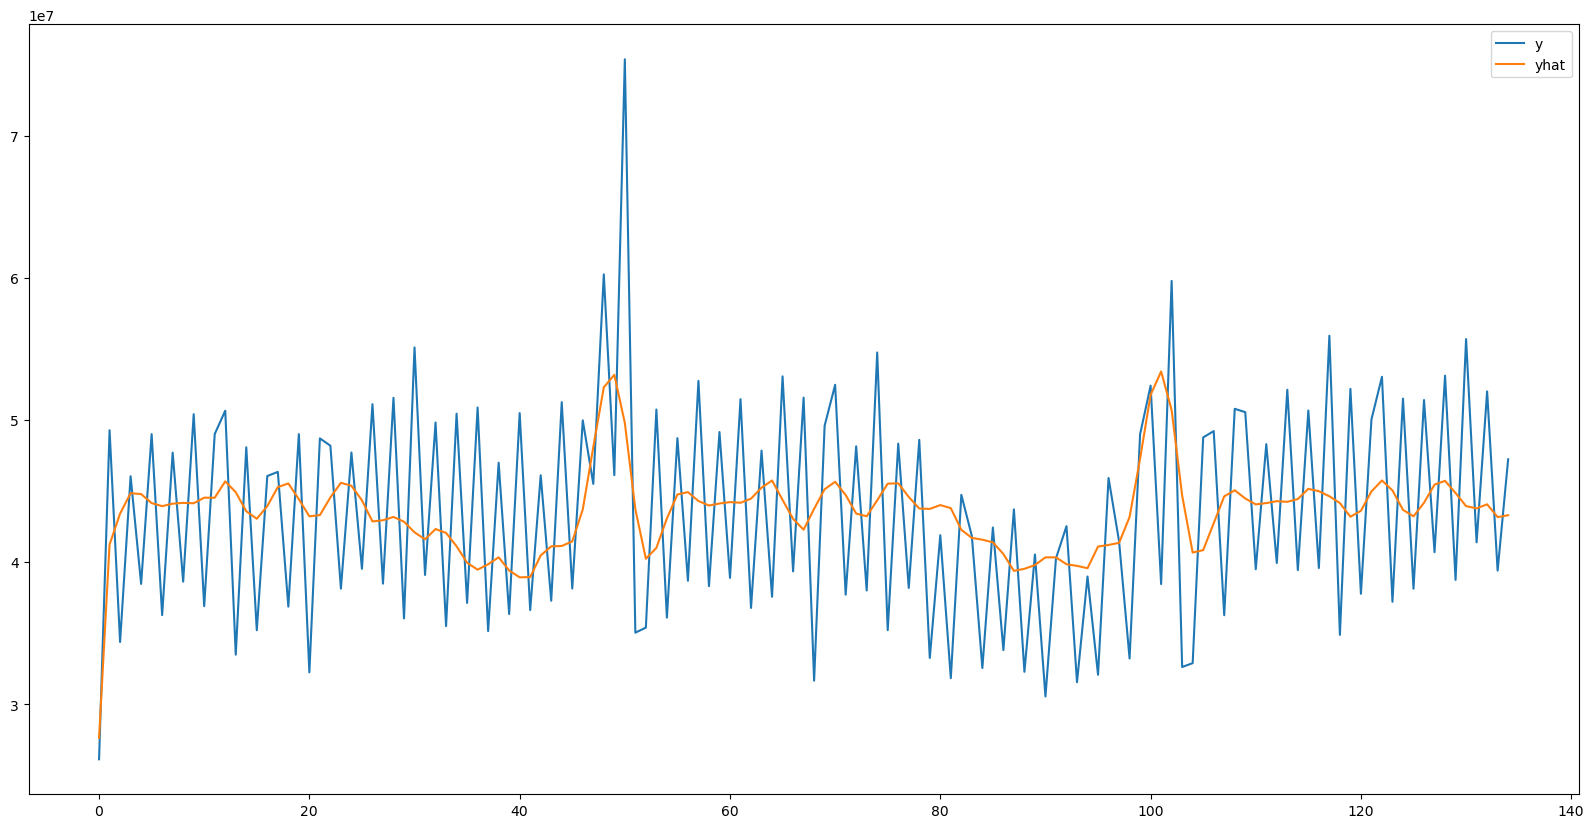

In [137]:
# Visualizing the performance of model
plt.figsize=(10,20)
metric_prophet_2["y"].plot(figsize=(20,10))
metric_prophet_2["yhat"].plot()
plt.legend()
plt.show()

### Final Prophet model:
- Baseline Prophet model used default parameters and we got RMSE of 53782649094881.14
- After hyper tuning, we got RMSE of 52478331938232.15.
- Although the final model is performing better it is still performing poorly as compared to ARIMA. So, let's try another model.

## Model 3 - XGBoost
We'll need to convert all categorical variables into numerical/dummy variables in order to implement XGBoost. We'll also drop columns that are correlated (e.g Customers, Sale Per Customer) in addition to merging similar columns into one column (CompetitionOpenSinceMonth, CompetitionOpenSinceYear).

In [138]:
# Dropping Customers and Sale per customer
ts_xgboost = train_store_joined.copy()
ts_xgboost = ts_xgboost.drop(['Customers', 'SalePerCustomer', 'PromoInterval'], axis=1)

In [139]:
# Combining similar columns into one column and dropping old columns
ts_xgboost['CompetitionOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.CompetitionOpenSinceYear) + (ts_xgboost.Month - ts_xgboost.CompetitionOpenSinceMonth)
ts_xgboost['PromoOpen'] = 12 * (ts_xgboost.Year - ts_xgboost.Promo2SinceYear) + (ts_xgboost.WeekOfYear - ts_xgboost.Promo2SinceWeek) / 4.0
ts_xgboost = ts_xgboost.drop(["CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"], axis = 1)
ts_xgboost = ts_xgboost.drop(["Promo2SinceWeek", "Promo2SinceYear"], axis = 1)

In [140]:
# Converting categorical cols to numerical cols and removing old cols
mappings = {0:0, "0": 0, "a": 1, "b": 1, "c": 1}
ts_xgboost["StateHoliday_cat"] = ts_xgboost["StateHoliday"].map(mappings)
ts_xgboost["StoreType_cat"] = ts_xgboost["StoreType"].map(mappings)
ts_xgboost["Assortment_cat"] = ts_xgboost["Assortment"].map(mappings)
ts_xgboost = ts_xgboost.drop(["StateHoliday", "StoreType", "Assortment"], axis = 1)

In [141]:
# Splitting the data
features = ts_xgboost.drop(["Sales"], axis = 1)
target = ts_xgboost["Sales"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(features, target, test_size = 0.20) 

### Initial/Baseline XGBoost

In [142]:
# Tuning parameters - using default metrics
params = {'max_depth':6, "booster": "gbtree", 'eta':0.3, 'objective':'reg:linear'} 

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost = xgb.train(params, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds = xgboost.predict(dtest)

[0]	train-rmse:3217.20512	eval-rmse:3214.92412
[1]	train-rmse:2848.50244	eval-rmse:2843.85228
[2]	train-rmse:2641.53088	eval-rmse:2635.59053
[3]	train-rmse:2526.82889	eval-rmse:2519.00289
[4]	train-rmse:2449.49967	eval-rmse:2442.49762
[5]	train-rmse:2398.51494	eval-rmse:2390.73878
[6]	train-rmse:2367.41602	eval-rmse:2359.92507
[7]	train-rmse:2349.53683	eval-rmse:2342.20732
[8]	train-rmse:2324.68340	eval-rmse:2317.56155
[9]	train-rmse:2297.07204	eval-rmse:2290.88910
[10]	train-rmse:2288.33392	eval-rmse:2282.52670
[11]	train-rmse:2263.91485	eval-rmse:2258.90757
[12]	train-rmse:2196.68765	eval-rmse:2193.86297
[13]	train-rmse:2182.35858	eval-rmse:2179.71054
[14]	train-rmse:2173.98613	eval-rmse:2171.37030
[15]	train-rmse:2145.09369	eval-rmse:2144.61221
[16]	train-rmse:2119.64044	eval-rmse:2119.65991
[17]	train-rmse:2104.80812	eval-rmse:2105.02230
[18]	train-rmse:2058.97553	eval-rmse:2061.24799
[19]	train-rmse:2017.24706	eval-rmse:2020.32728
[20]	train-rmse:2004.85944	eval-rmse:2008.42882
[2

In [143]:
# RMSE of model
rms_xgboost = sqrt(mean_squared_error(y_test, preds))
print("Root Mean Squared Error for XGBoost:", rms_xgboost)

Root Mean Squared Error for XGBoost: 1239.39905936546


### Hypertuning XGBoost
Now let's try to decrease the RMSE of XGBoost by passing different values for our hyperparameters in the XGBoost model.

- eta: It defines the learning rate i.e step size to learn the data in the gradient descent modeling (the basis for XGBoost). The default value is 0.3 but we want to keep the learning rate low to avoid overfitting. So, we'll choose 0.2 as eta
- max_depth: Maximum depth of a tree. The default value is 6 but we want our model to be more complex and find good predictions. So, let's choose 10 as max depth.
- gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be. The default value is 0, let's choose a little higher value so as to get good predictions

In [144]:
# Tuning parameters
params_2 = {'max_depth':10, 'eta':0.1,  'gamma': 2}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Training the model
xgboost_2 = xgb.train(params_2, dtrain, 100, evals=watchlist,early_stopping_rounds= 100, verbose_eval=True)
         
# Making predictions
preds_2 = xgboost_2.predict(dtest)

[0]	train-rmse:3603.33728	eval-rmse:3603.74000
[1]	train-rmse:3390.55474	eval-rmse:3390.46050
[2]	train-rmse:3203.98231	eval-rmse:3204.39482
[3]	train-rmse:3045.85527	eval-rmse:3046.43618
[4]	train-rmse:2903.28139	eval-rmse:2904.06163
[5]	train-rmse:2784.55638	eval-rmse:2785.61210
[6]	train-rmse:2680.89128	eval-rmse:2681.97189
[7]	train-rmse:2591.22802	eval-rmse:2593.18130
[8]	train-rmse:2514.04847	eval-rmse:2516.18615
[9]	train-rmse:2448.78630	eval-rmse:2451.33123
[10]	train-rmse:2387.43399	eval-rmse:2390.60867
[11]	train-rmse:2344.31139	eval-rmse:2347.82717
[12]	train-rmse:2296.80087	eval-rmse:2301.05393
[13]	train-rmse:2255.62798	eval-rmse:2260.60512
[14]	train-rmse:2223.90194	eval-rmse:2229.41118
[15]	train-rmse:2193.33679	eval-rmse:2199.09821
[16]	train-rmse:2149.70717	eval-rmse:2155.65596
[17]	train-rmse:2131.15536	eval-rmse:2137.85224
[18]	train-rmse:2112.57394	eval-rmse:2119.82058
[19]	train-rmse:2091.15021	eval-rmse:2098.65012
[20]	train-rmse:2061.25124	eval-rmse:2069.85200
[2

In [145]:
# RMSE of model
rms_xgboost_2 = sqrt(mean_squared_error(y_test, preds_2))
print("Root Mean Squared Error for XGBoost:", rms_xgboost_2)

Root Mean Squared Error for XGBoost: 1095.9149257992306


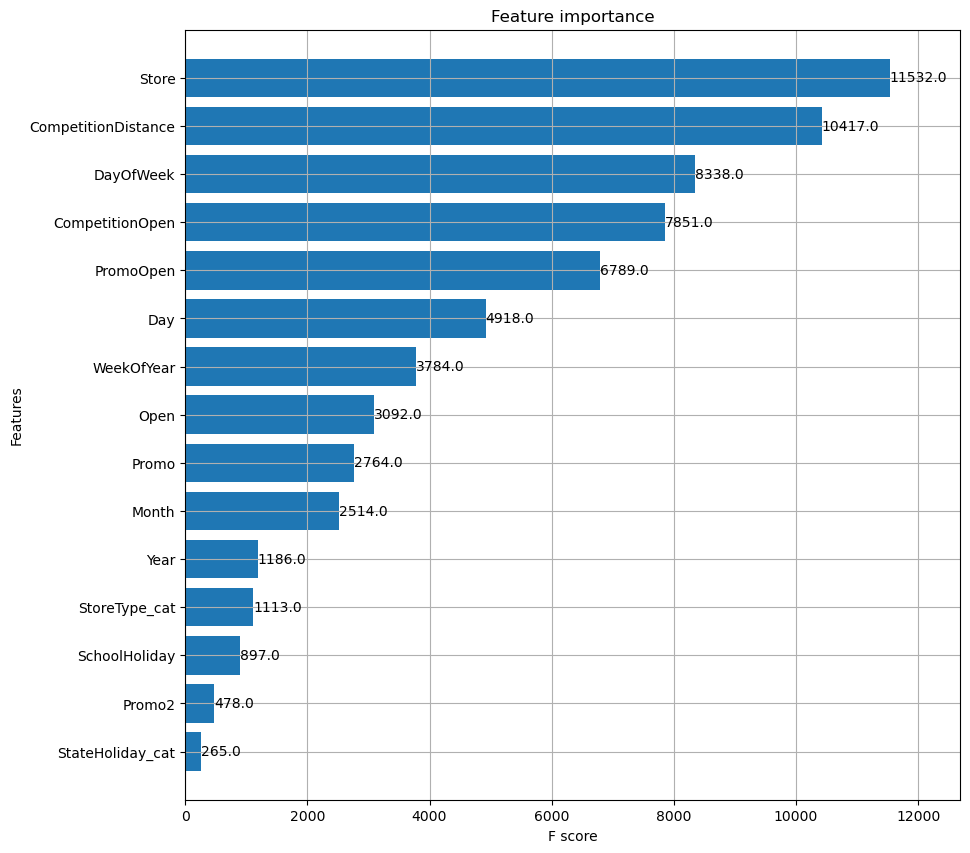

In [146]:
# Let's see the feature importance
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgboost_2, max_num_features=50, height=0.8, ax=ax)
plt.show()

### Final XGBoost Model:
After hypertuning, we were able to reduce RMSE from 1226.99 to 1191.90, which is great! Now, let's compare the performance of all models

### Results

In [147]:
# Comparing performance of above three models - through RMSE
rms_arima = format(float(rms_arima))
rms_prophet_2 = format(float(rms_prophet_2))
rms_xgboost_2 = format(float(rms_xgboost_2))

model_errors = pd.DataFrame({
    "Model": ["SARIMA", "Prophet", "XGBoost"],
    "RMSE": [rms_arima, rms_prophet_2, rms_xgboost_2]
})

model_errors.sort_values(by = "RMSE")

,Model,RMSE
2,XGBoost,1095.9149257992306
1,Prophet,52478275861356.875
0,SARIMA,739.0611673647138


### Model Comparison & Selection

We used the Root Mean Squared Error (RMSE) to evaluate and validate the performance of various models used. Let's see which model performed better and why/why not.

a) We can see from the above table that SARIMA performs the best followed by XGBoost and Prophet.

b) It makes sense because SARIMA is designed specifically for seasonal time series data while XGBoost is a general (though powerful) machine learning approach with various applications.

c) Prophet is a good choice for producing quick forecasts as it doesn't require strong technical skills. It is easy to implement at scale. The reason for its poor performance here is probably because of a lack of data. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Based on the above analysis, we'll choose ARIMA as our final model to predict the sales because it gives us the least RMSE and is well suited to our needs of predicting time series seasonal data. We chose ARIMA(1, 1, 1)x(0, 1, 1, 12)12 as the final parameter combination with AIC of 1806.29 and RMSE of 739.06.

### Conclusions

Our task was to predict the sales of each store for next month. We started by exploring the time series data and then did some feature engineering to prepare the data for modelling. Finally, we used various modelling techniques such as SARIMA, Prophet and XGBoost to predict the sales. SARIMA, a model designed specifically for time series performed the best. We also plotted the truth vs predicted sales to understand the performance of model in addition to calcualting squared mean error.








#### Reflection
- The most interesting thing about the project was that the category of stores having the highest sales don't have the highest sale per customer. It might be because those stores sell small items, which are needed on a daily basis.

- Another interesting thing was that running a promotion for the second time doesn't help in increasing sales. It is probably because customers already purchased whatever they wanted during the first promotional sale.

#### Improvement Areas: 
- We could have used the tranformation techniques to smoothen the data e.g using Moving Average, Log transformation etc. to remove seasonality and trend and make the time series more stationary. After building the model, we would have introduced the behavior of seasonality and trend back to the results. This might have resulted in a better model with a lower RMSE.


- We could also use SARIMAX model that take exogenous variables. These are the variables whose value is determined outside the model and is imposed on the model. In other words, variables that affect a model without being affected by it. For example, Competition Open, Promo Open, etc.
